## Student Id- 23242949
## Name: Jitendra Upadhyay

In [45]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (ColumnTransformer, TransformedTargetRegressor)
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.preprocessing import (StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import SVR
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## EDA

In [2]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [3]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

#### There are 1337 rows and 7 columns

In [4]:
df['gender'].value_counts()

male      676
female    662
Name: gender, dtype: int64

In [5]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [6]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [7]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

#### There are no missing values

There are no missing values. Let's check the boxplots of the numerical columns for outliers.

In [8]:
df.describe()
#df.loc[:,:].describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

<Axes: >

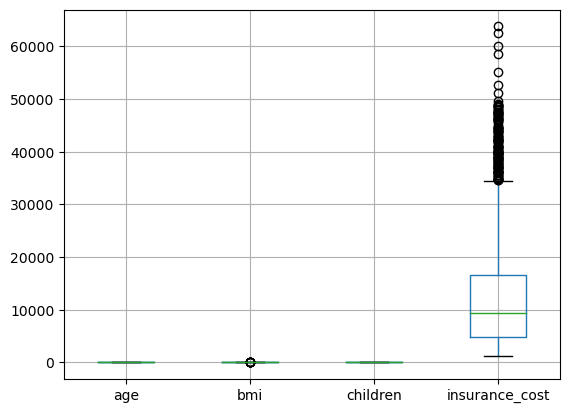

In [9]:
df.boxplot()

#### The above plots are not readable, lets look at them separately

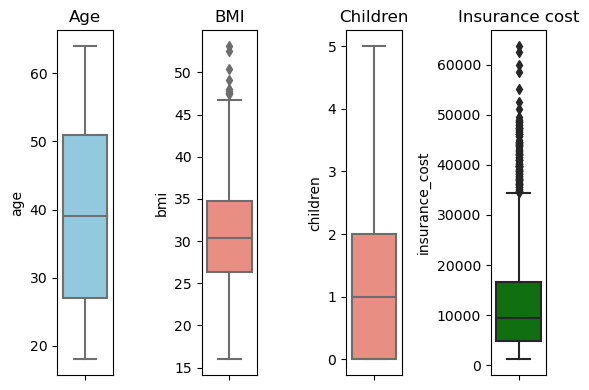

In [10]:
import seaborn as sns
# Box plots for numerical attributes
plt.figure(figsize=(10, 4))

# Box plot for 'age'
plt.subplot(1, 7, 1)
sns.boxplot(y='age', data=df, color='skyblue')
plt.title('Age')

# Box plot for 'bmi'
plt.subplot(1, 7, 2)
sns.boxplot(y='bmi', data=df, color='salmon')
plt.title('BMI')

# Box plot for 'children'
plt.subplot(1, 7, 3)
sns.boxplot(y='children', data=df, color='salmon')
plt.title('Children')

# Box plot for 'insurance_cost'
plt.subplot(1, 7, 4)
sns.boxplot(y='insurance_cost', data=df, color='green')
plt.title('Insurance cost')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'insurance_cost'}>]], dtype=object)

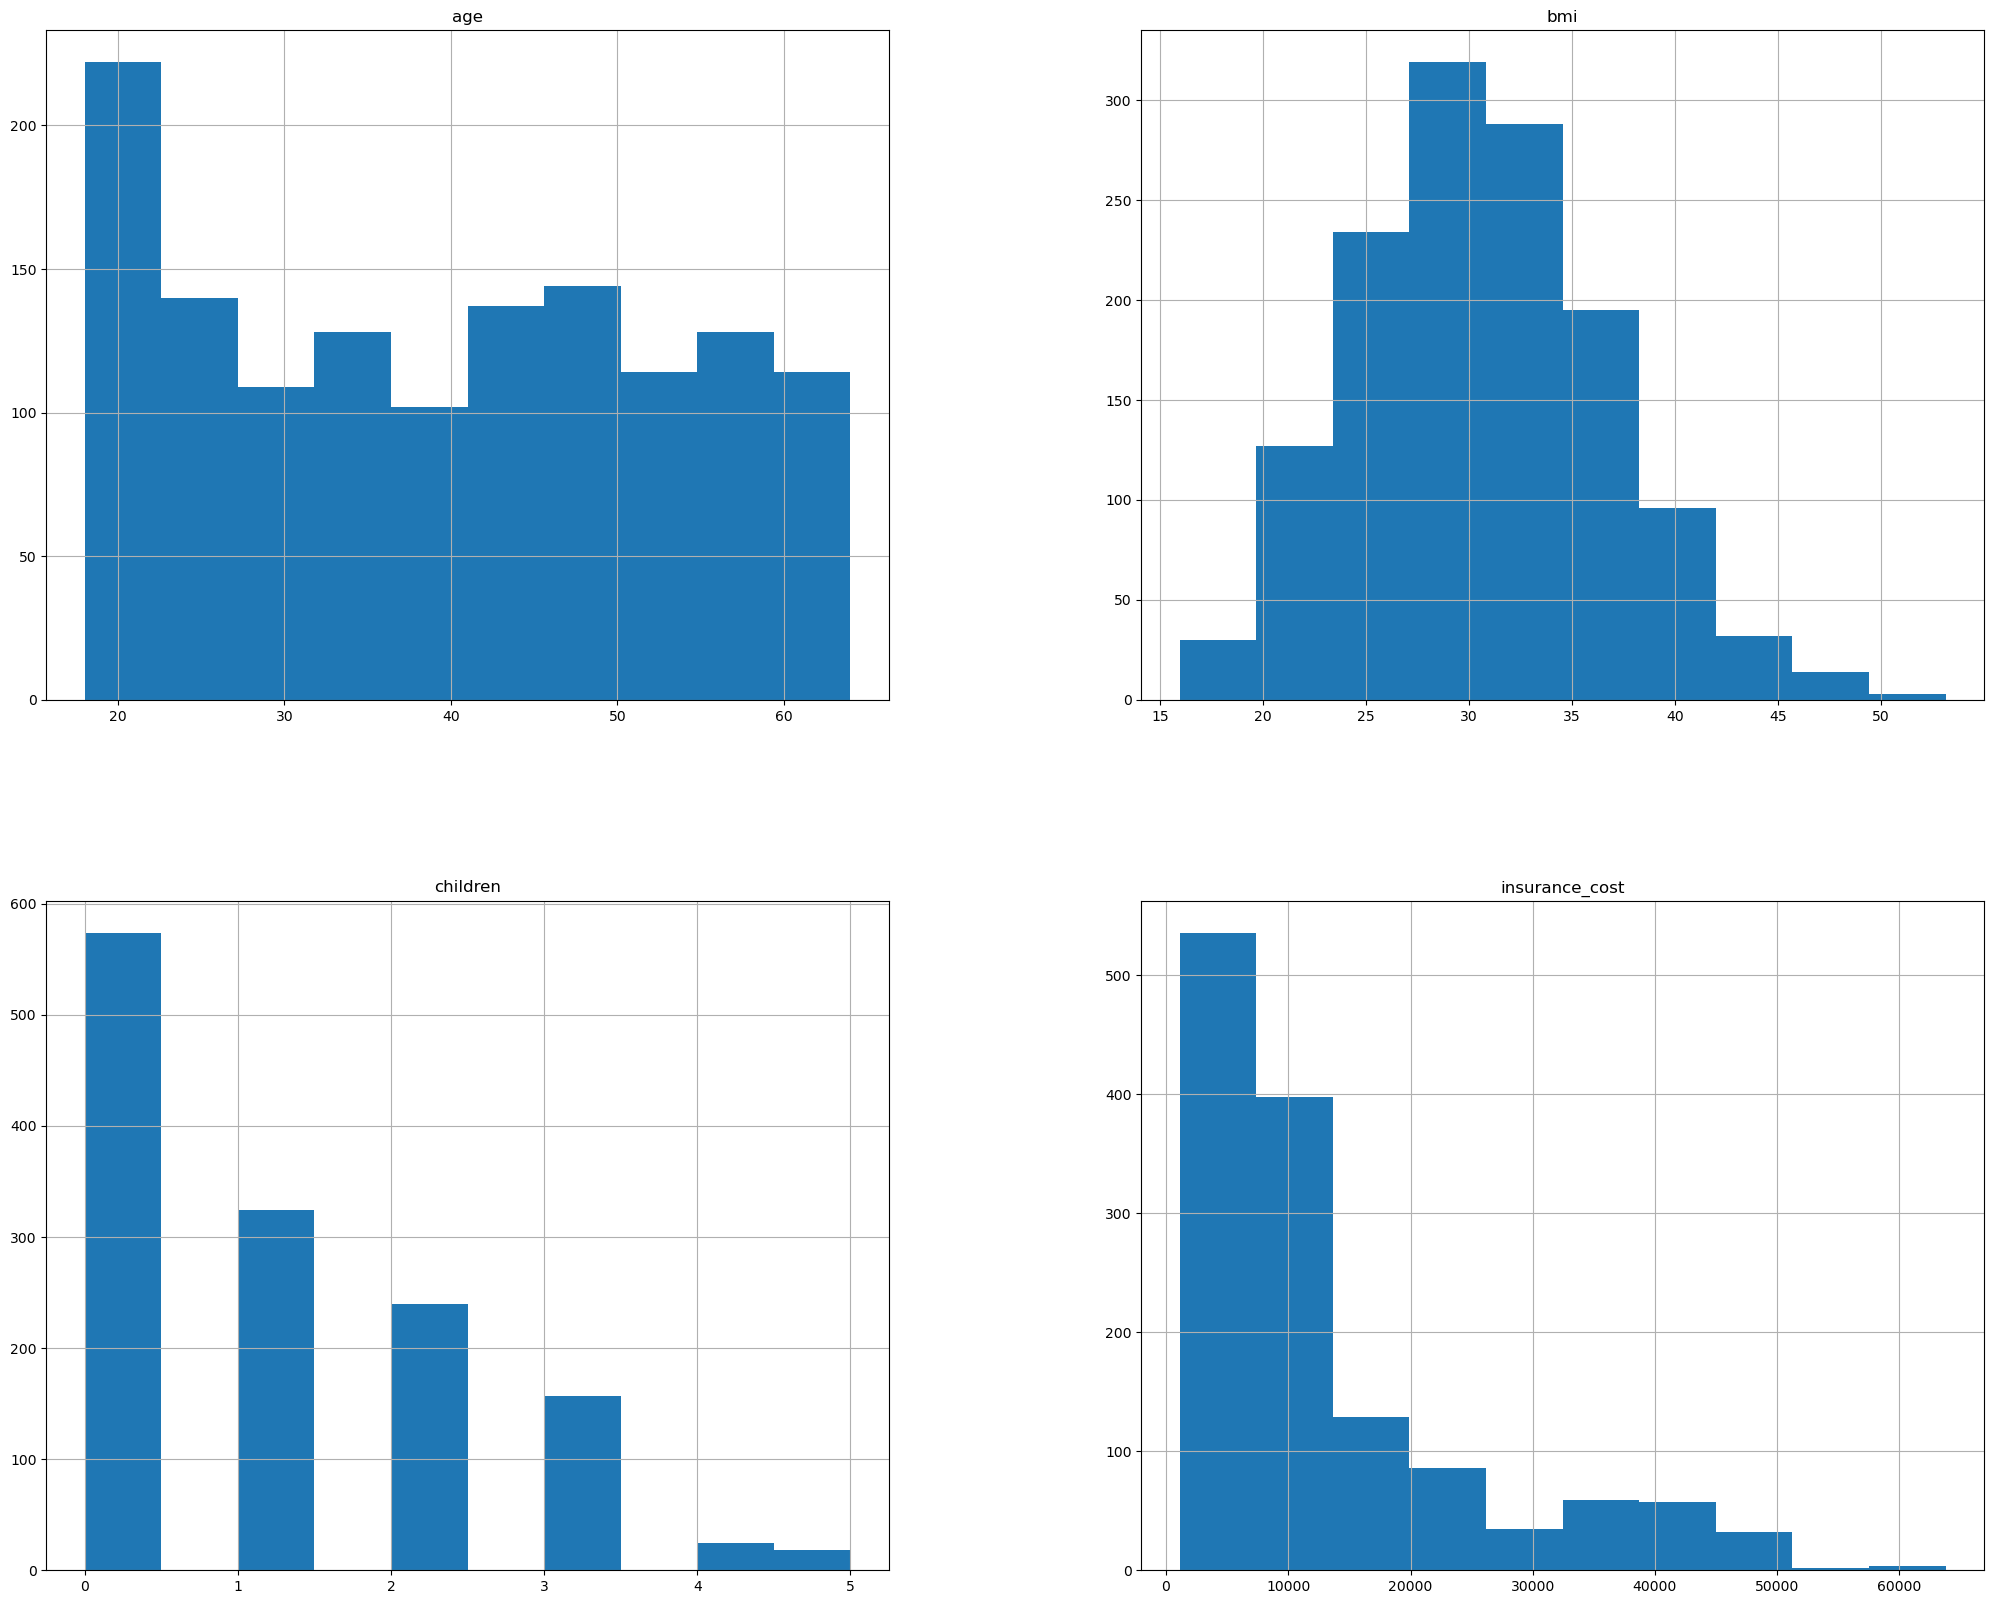

In [11]:
df.hist(bins=10, figsize=(25, 20))

In [12]:
# Calculate skewness for specific columns
skewness_age = df['age'].skew()
skewness_bmi = df['bmi'].skew()
skewness_children = df['children'].skew()
skewness_insurance_cost = df['insurance_cost'].skew()

# Print the skewness for each column
print("Skewness for Age:", skewness_age)
print("Skewness for BMI:", skewness_bmi)
print("Skewness for Children:", skewness_children)
print("Skewness for Insurance Cost:", skewness_insurance_cost)


Skewness for Age: 0.05567251565299176
Skewness for BMI: 0.2840471105987448
Skewness for Children: 0.9383804401702414
Skewness for Insurance Cost: 1.5158796580240386


Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. If the skewness is positive, it means that the right tail, the distribution has a few very large values, which can result in a longer right tail. If the skewness is negative, it means that the left tail (smaller values) of the distribution is longer or fatter than the right tail.A skewness value close to zero indicates that the distribution is approximately symmetric.

### Part of the question
First of all, replace the column `insurance_cost` with a binary column `insurance_cost_binary`, where `insurance_cost_binary` is 0 if the corresponding `insurance_cost` is less than or equal to the median insurance cost and 1 otherwise. 

## Data Preparation

#### From the calculation of skewness, there is skewness for for Children, so we will drop that.
First, let's drop the data row with children 0.

In [13]:
df = df.drop(df[df.children == 0].index)

Next we split the columns into a target *`y`* and predictors *`X`*.

In [14]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1)

In [47]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# Define preprocessing steps for numerical and categorical features
numeric_features = ['age', 'bmi', 'children']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['gender', 'smoker', 'region']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [49]:
# Define regressors
regressors = {
    'SVR': SVR(),
    'MLPRegressor': MLPRegressor(max_iter=1000),
    'LinearRegression': LinearRegression()
}

# Define dimensionality reduction techniques
reducers = {
    'PCA': PCA(),
    'RFE': RFE(estimator=LinearRegression()),
    'LDA': LDA()
}

# Define hyperparameters grid for each regressor
param_grids = {
    'SVR': {'regressor__C': [0.1, 1, 10],
            'regressor__kernel': ['linear', 'rbf']},
    'MLPRegressor': {'regressor__hidden_layer_sizes': [(50,), (100,), (50, 50)],
                     'regressor__alpha': [0.0001, 0.001, 0.01]},
    'LinearRegression': {}
}

In [56]:
# Create pipelines for each combination of regressor and dimensionality reduction technique
pipelines = {}
for regressor_name, regressor in regressors.items():
    for reducer_name, reducer in reducers.items():
        pipeline_steps = [
            ('preprocessor', preprocessor),
            #('reducer', reducer),
            ('regressor', regressor)
        ]
        pipeline = Pipeline(steps=pipeline_steps)
        pipelines[f'{regressor_name}_{reducer_name}'] = pipeline

In [57]:
# Apply grid search for hyperparameter tuning
for pipeline_name, pipeline in pipelines.items():
    print(f"Training pipeline: {pipeline_name}")
    param_grid = param_grids[pipeline_name.split('_')[0]]
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    print("Best parameters found:")
    print(grid_search.best_params_)
    print("Best cross-validation score:")
    print(grid_search.best_score_)

Training pipeline: SVR_PCA
Best parameters found:
{'regressor__C': 10, 'regressor__kernel': 'linear'}
Best cross-validation score:
-138992631.95517927
Training pipeline: SVR_RFE
Best parameters found:
{'regressor__C': 10, 'regressor__kernel': 'linear'}
Best cross-validation score:
-138992631.95517927
Training pipeline: SVR_LDA
Best parameters found:
{'regressor__C': 10, 'regressor__kernel': 'linear'}
Best cross-validation score:
-138992631.95517927
Training pipeline: MLPRegressor_PCA


C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warning

C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warning

Best parameters found:
{'regressor__alpha': 0.001, 'regressor__hidden_layer_sizes': (50, 50)}
Best cross-validation score:
-29820384.659552116
Training pipeline: MLPRegressor_RFE


C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warning

C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warning

Best parameters found:
{'regressor__alpha': 0.01, 'regressor__hidden_layer_sizes': (50, 50)}
Best cross-validation score:
-30198446.100746524
Training pipeline: MLPRegressor_LDA


C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warning

C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warning

Best parameters found:
{'regressor__alpha': 0.0001, 'regressor__hidden_layer_sizes': (50, 50)}
Best cross-validation score:
-30659351.833120715
Training pipeline: LinearRegression_PCA
Best parameters found:
{}
Best cross-validation score:
-37344234.942938656
Training pipeline: LinearRegression_RFE
Best parameters found:
{}
Best cross-validation score:
-37344234.942938656
Training pipeline: LinearRegression_LDA
Best parameters found:
{}
Best cross-validation score:
-37344234.942938656


C:\Users\Jitendra Upadhyay\AnacondaJitendra\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [60]:
 # Evaluate on test data
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

Mean Squared Error on Test Set: 36000021.71074948


- Data Loading:We did data loading and then data exploration.

- Data Visualization: We used seaborn to create box plots for numerical attributes.

- Data Preprocessing: We defined preprocessing steps for numerical features (scaling) and categorical features (one-hot encoding) using sklearn's preprocessing modules.

- Model Selection and Setup: We selected three regression algorithms (SVR, MLPRegressor, and Linear Regression) and defined their initial setups. Additionally, we defined dimensionality reduction techniques.

- Pipeline Creation: We created pipelines for each combination of regressor and dimensionality reduction technique.

- Hyperparameter Tuning: Grid search with cross-validation was applied to each pipeline to find the best combination of hyperparameters for each model. This step helps optimize model performance.

- Model Evaluation: After hyperparameter tuning, the best models from each pipeline were evaluated on the test set using mean squared error as the evaluation metric.